#**ASSIGMENT ONE:** Bag of Words implementation for Sentiment analysis 💭


Once Jeff finished his coffee, he settled into his desk at Amazon's bustling headquarters in Seattle. As a data analyst at the world's largest online retailer, Jeff was accustomed to diving deep into the ocean of data generated by millions of transactions every day.

Today, Jeff had a new challenge on his plate. The marketing team wanted to gain insights into customer sentiment regarding their latest products. Specifically, they were interested in understanding whether customers were generally satisfied or dissatisfied with their purchases.

After pondering over various approaches, Jeff decided to task his team of interns with a hands-on assignment to implement Bag of Words (BoW) and Naive Bayes classification for sentiment analysis on Amazon reviews.

As an intern is your task to complete this challenge the best way possible to impress your boss and hopefully get a full time position at the company.  

The following notebook will guide you into how to create your BoW implementation for sentiment analysis and hopefully make jeff happy 🤭

As a first step we need to get all of our data ready

In [ ]:
#download train and test set
!gdown  https://drive.google.com/file/d/1bcnYdTHuY2pr4py5tG-HtNU73pJzRH7U/view?usp=sharing --fuzzy
!gdown  https://drive.google.com/file/d/1T19F6Oge0-qHMqX_IKiU_l94Y1k2oLJp/view?usp=sharing --fuzzy

In [ ]:
#unzip
!unzip train.ft.zip
!unzip test.ft.zip

Our txts has the following format


```
__label__#  This is a review ....

```

As you see the first word refers to the label, `__label__1` corresponds to 1- and
2-star reviews(negative sentiment) and `__label__2` corresponds to to 4- and 5-star reviews (positive sentiment).

Normally reviews are very messy including words with incorrect spelling, different formats and a lot of words that do not add any value to our classification. Let's create a method to clean them

In [1]:
#import nltk libray, you are going to need this later
import nltk
import pandas as pd
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dorro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import string
import re
from nltk.corpus import stopwords

def preprocess_text(text):
  """ Method to clean reviews from noise and standarize text across the different classes.
      The preprocessing includes converting to lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : String
     Text to clean
  Returns
  -------
  text : String
      Cleaned text
  """
  stop_words = set(stopwords.words('english'))

  text = text.lower() #make everything lower case
  text = text.strip() #remove \n characters
  text = re.sub(r'[^\w\s]', ' ', text) #remove any punctuation or special characters
  text = re.sub(r'\d+', ' ', text) #remove numbers
  words = text.split()
  text = ' '.join([w for w in words if w not in stop_words]) #remove all stopwords (see imports to help you with this)

  return text

In [4]:
preprocess_text("hello4world")

'hello world'

It's also useful to have our data organized and ready to access! A great library for this is [pandas](https://pandas.pydata.org/). In the folowing code cell you will create a dataframe containing all the data provided in the training document. Please be patient this code cell can take up to 10 min (is a big dataset!)

In [6]:
def create_dataframe(path_to_file):
  """ Creates dataframe of reviews and labels
  Arguments
  ---------
  path_to_file : str
      path to file to read
  Returns
  -------
  df : pandas dataframe
      Dataframe of reviews and labels
  """
  df={}
  index= 0
  with open(path_to_file) as f:
    for line in f:
      if index > 200:
        break
      label_text, text = line.split(' ', 1)  #get label and review from line in file
      label = 0 if label_text == '__label__1' else 1 # get numeric value of label_text. If label_text is __label__1 then label = 0 if __label__2 label = 1
      text = preprocess_text(text) #preprocess text
      df[index] = {"label": label, "text": text} #create dictionary with keys "label" and "text" and set the correct values
      index+=1
  return pd.DataFrame.from_dict(df,orient='index')

In [7]:
df_train= create_dataframe('train.ft.txt')
df_test= create_dataframe('test.ft.txt')

In [9]:
len(df_test)

201

In [10]:
def vocab_dictionary(df):
  """ Creates dictionary of frequencies based on a dataset of reviews
  Arguments
  ---------
  df : list of tuples
      list of tuples of the form (label, text)
  Returns
  -------
  vocab_dict : dictonary
      Dictionary of words and their frequencies with the format {word: frequency}
  """

  vocab = {} #create empty dictionary

  #iterate through rows of df and count the frequency of words
  for text in df['text']:
    words = text.split()
    for word in words:
      if word not in vocab:
        vocab[word] = 1
      else:
        vocab[word] += 1

  return vocab

In [12]:
full_vocab=vocab_dictionary(df_train)
positive_vocab = vocab_dictionary(df_train[df_train['label']==1]) #We create a positive vocab to keep track of words in positive reviews. This will come in handy later
negative_vocab = vocab_dictionary(df_train[df_train['label']==0]) #We create a negative vocab to keep track of words in negative reviews. This will come in handy later

In [13]:
print(len(full_vocab))

3175


In [14]:
print(len(positive_vocab)/len(negative_vocab))

1.12


Let's take a look to out training vocabulary, in the following cell create a sorted dictionary by frequency from most frequent to less frequent tokens

In [15]:
vocab_sorted = sorted(full_vocab.items(), key=lambda x: x[1], reverse=True) #sort full_vocab from words with high frequency to low frequency

In [19]:
from itertools import islice

first_tokens = vocab_sorted[len(vocab_sorted)-45:] # Take first 30 tokens of each vocabulary

In order to see Zip's law first hand, let's plot the first 30 most frequent words of each vocabulary

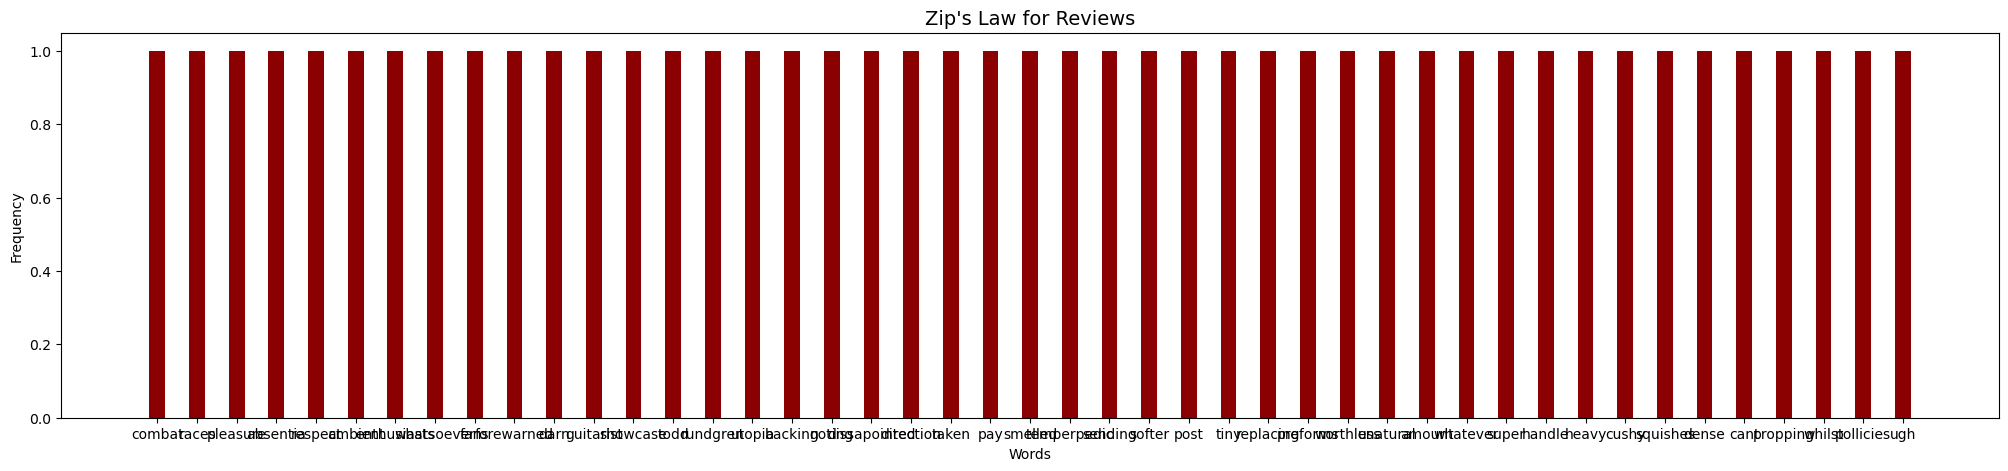

In [20]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (25, 5))

#TODO: Create bar chart of the 30 most frequent words in positive reviews with appropriate title and axis labels
words, frequencies = zip(*first_tokens)
plt.bar(words, frequencies, color='darkred', width=0.4)

plt.title('Zip\'s Law for Reviews', fontsize=14)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.show()

Let's check the size of our vocabulary

In [21]:
print('Vocabulary size:',len(full_vocab))

Vocabulary size: 3175


Now that our reviews are "clean" let's start the real work. Naive bayes includes three important components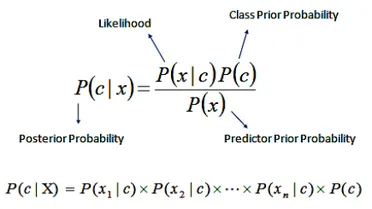

We need to calculate two things for the posterior probability: the likelihood and the class prior probability (since is naive bayes we ignore the predictor prior probability)

Let's first calculate the class prior probability. This meaning the probability a review is positive or negative without taking into account the content.

In [22]:
positive_prior = len(df_train[df_train['label'] == 1]) / len(df_train) #calculate positive prior
negative_prior = len(df_train[df_train['label'] == 0]) / len(df_train) #calculate negative prior

Now let's create a method to calculate the log likelihood of each word in our vocabulary

In [23]:
import math
SMOOTHING_FACTOR = 0.2
def calculate_log_likelihood(vocab, positive_vocab, negative_vocab, smoothing_factor=SMOOTHING_FACTOR):
  """ Calculates log likelihood of words belonging to a positive or negative review given a dataset and vocabulary
  Arguments
  ---------
  dataset : list of tuples
      List of positive or negative reviews with their respective label (label, text)
  vocab : dictionary
      Vocabulary of words in the dataset with their respective frequencies
  Returns
  -------
  likelihood : dictionary of dictionaries
      Dictionary of words and their positive and negative log likelihood with format {word: {'positive': log_likelihood, 'negative': log_likelihood}}
  """
  likelihood = {}
  # TODO: create a dictionary with the log likelihoods of each word
  number_instances_positive = sum(positive_vocab.values()) #number of words in positive_vocab
  number_instances_negative = sum(negative_vocab.values()) #number of words in negative_vocab
  number_types = len(vocab) #number of words in all vocab (vocab size)


  for word, count in vocab.items():
    likelihood[word] = {}
    # TODO: Calculate positive and negative log likelihood for EACH word.

    #word count (0 if not found)
    positive_count = positive_vocab.get(word, 0)
    negative_count = negative_vocab.get(word, 0)

    #log likelihood
    positive_likelihood = (positive_count + smoothing_factor) / (number_instances_positive + smoothing_factor * number_types)
    likelihood[word]['positive'] = math.log(positive_likelihood)
    negative_likelihood = (negative_count + smoothing_factor) / (number_instances_negative + smoothing_factor * number_types)
    likelihood[word]['negative'] = math.log(negative_likelihood)

    # IMPORTANT: remember some words might be in positives but not negatives (or the other way around, thats why we use the smoothing factor!)

  return likelihood

In [29]:
math.log(2)

0.6931471805599453

In [24]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab)

Let's make sure we don't have any bugs till now

In [25]:
assert round(sum([math.exp(likelihood[word]['positive']) for word in likelihood]))==1 , "There is probably a bug calculating the positive log likelihood"
assert round(sum([math.exp(likelihood[word]['negative']) for word in likelihood]))==1 , "There is probably a bug calculating the negative log likelihood"
print("Great job! Keep going!")

Great job! Keep going!


Now the most essential function in our program, the method to actually classify unseen reviews.

In [26]:
def classify_review(text, likelihood, positive_prior, negative_prior):

    """ Calculates log scores for a new text given some prior probabilities and likelihoods
    Arguments
    ---------
    text : string
        Text to classify
    likelihood_positive : dictionary
        Dictionary of words and their log likelihood for positive reviews
    likelihood_negative : dictionary
        Dictionary of words and their log likelihood for negative reviews
    positive_prior : float
        Prior probability of a review being positive
    negative_prior : float
        Prior probability of a review being negative
    Returns
    -------
    predicted sentiment : string
        Predicted sentiment of the text
    sentiment_scores : tuple or dictionary
        Tuple of positive and negative sentiment scores
    """
    tokens = preprocess_text(text).split() # Preprocess the input review

    # Calculate the log scores for each sentiment category (take into account value for unseen tokens)
    log_score_positive = math.log(positive_prior)
    log_score_negative = math.log(negative_prior)

    for token in tokens:
        if token in likelihood:
            log_score_positive += likelihood[token]['positive']
            log_score_negative += likelihood[token]['negative']

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    predicted_sentiment = 'positive' if log_score_positive > log_score_negative else 'negative' # Determine the predicted sentiment based on the highest sentiment score

    return predicted_sentiment, sentiment_scores

In [30]:
text="This hair dryer is terribly bad, it doesn't work at all"
predicted_sentiment, sentiment_scores = classify_review(text, likelihood,
                               positive_prior, negative_prior)
print(predicted_sentiment)
print(sentiment_scores)
#You should see here a correct prediction of negative

negative
{'positive': -22.42566208149622, 'negative': -22.06096335401051}


In [31]:
text='This product was amazing I would buy it again'
predicted_sentiment, sentiment_scores = classify_review(text, likelihood,
                               positive_prior, negative_prior)
print(predicted_sentiment)
print(sentiment_scores)
#You should see here a correct prediction of positive

positive
{'positive': -25.206722086523122, 'negative': -27.291851216176035}


## Let's test our model

In all machine learning workflows is essential to test how well our model does with unseen data. Let's try testing the model with the provided test dataframe we created at the beggining, you remember?

In [32]:
true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.7706422018348624
Recall:  0.7706422018348624
F1 Score:  0.7706422018348624


## Let's Experiment

Document any changes after this cell

Now it's your time to experiment to impress Jeff:

1.   modify the smoothing factor (use three different values)
1.   try using the raw texts withour any pre-processing techniques

Analyse and report how these modifications affect the predictions of your model(see more in handout)

# Trying different smoothing factors

In [ ]:
likelihood = calculate_log_likelihood(full_vocab, positive_vocab, negative_vocab, 0.4)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.8543162816700973
Recall:  0.840455
F1 Score:  0.8473289561568222


In [ ]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.6)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.8546772611040786
Recall:  0.840605
F1 Score:  0.8475827247817659


In [ ]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.8)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.8550184361093452
Recall:  0.84059
F1 Score:  0.8477428301292153


# Using data without preprocessing the text

In [7]:
def create_dataframe_without_preprocess(path_to_file):
  """ Creates dataframe of reviews and labels
  Arguments
  ---------
  path_to_file : str
      path to file to read
  Returns
  -------
  df : pandas dataframe
      Dataframe of reviews and labels
  """
  df={}
  index= 0
  with open(path_to_file) as f:
    for line in f:
      label_text, text = line.split(' ', 1)  #get label and review from line in file
      label = 0 if label_text == '__label__1' else 1 # get numeric value of label_text. If label_text is __label__1 then label = 0 if __label__2 label = 1
      df[index] = {"label": label, "text": text} #create dictionary with keys "label" and "text" and set the correct values
      index+=1
  return pd.DataFrame.from_dict(df,orient='index')

df_train = create_dataframe_without_preprocess('train.ft.txt')
df_test = create_dataframe_without_preprocess('test.ft.txt')

full_vocab = vocab_dictionary(df_train)
positive_vocab = vocab_dictionary(df_train[df_train['label']==1]) #We create a positive vocab to keep track of words in positive reviews. This will come in handy later
negative_vocab = vocab_dictionary(df_train[df_train['label']==0]) #We create a negative vocab to keep track of words in negative reviews. This will come in handy later

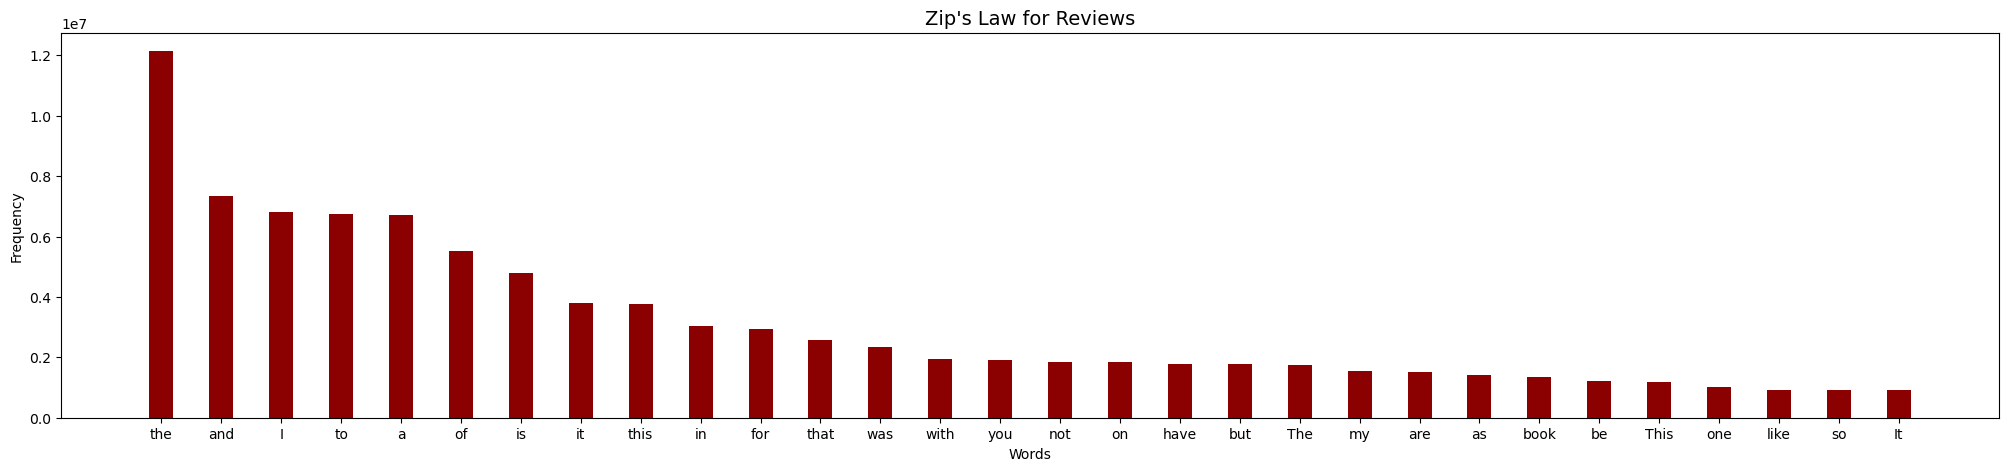

Vocabulary size: 5165172


In [14]:
import matplotlib.pyplot as plt

vocab_sorted = sorted(full_vocab.items(), key=lambda x: x[1], reverse=True) #sort full_vocab from words with high frequency to low frequency

first_tokens = vocab_sorted[:30] # Take first 30 tokens of each vocabulary

fig = plt.figure(figsize = (25, 5))

#TODO: Create bar chart of the 30 most frequent words in positive reviews with appropriate title and axis labels
words, frequencies = zip(*first_tokens)
plt.bar(words, frequencies, color='darkred', width=0.4)

plt.title('Zip\'s Law for Reviews', fontsize=14)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.show()

print('Vocabulary size:',len(full_vocab))

In [8]:
positive_prior = len(df_train[df_train['label'] == 1]) / len(df_train) #calculate positive prior
negative_prior = len(df_train[df_train['label'] == 0]) / len(df_train) #calculate negative prior

In [9]:
def classify_review_without_preprocess(text, likelihood, positive_prior, negative_prior):

    """ Calculates log scores for a new text given some prior probabilities and likelihoods
    Arguments
    ---------
    text : string
        Text to classify
    likelihood_positive : dictionary
        Dictionary of words and their log likelihood for positive reviews
    likelihood_negative : dictionary
        Dictionary of words and their log likelihood for negative reviews
    positive_prior : float
        Prior probability of a review being positive
    negative_prior : float
        Prior probability of a review being negative
    Returns
    -------
    predicted sentiment : string
        Predicted sentiment of the text
    sentiment_scores : tuple or dictionary
        Tuple of positive and negative sentiment scores
    """
    tokens = text.split()

    # Calculate the log scores for each sentiment category (take into account value for unseen tokens)
    log_score_positive = math.log(positive_prior)
    log_score_negative = math.log(negative_prior)

    for token in tokens:
        if token in likelihood:
            log_score_positive += likelihood[token]['positive']
            log_score_negative += likelihood[token]['negative']

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    predicted_sentiment = 'positive' if log_score_positive > log_score_negative else 'negative' # Determine the predicted sentiment based on the highest sentiment score

    return predicted_sentiment, sentiment_scores

In [18]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.2)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_without_preprocess(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8783116392840705
Recall:  0.8492
F1 Score:  0.8635105282290764


In [12]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.4)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_without_preprocess(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8798839859125751
Recall:  0.84944
F1 Score:  0.8643940164851938


In [11]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.6)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_without_preprocess(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8806584148656921
Recall:  0.848805
F1 Score:  0.8644383678831671


In [10]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.8)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_without_preprocess(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


Precision:  0.881391432699604
Recall:  0.847925
F1 Score:  0.864334388363073


# What if we do preprocessing without deleting stopwords?

In [9]:
import re

def preprocess_text_2(text):
  """ Method to clean reviews from noise and standarize text across the different classes.
      The preprocessing includes converting to lowercase, removing punctuation, and removing stopwords.
  Arguments
  ---------
  text : String
     Text to clean
  Returns
  -------
  text : String
      Cleaned text
  """
  text = text.lower() #make everything lower case
  text = text.strip() #remove \n characters
  text = re.sub(r'[^\w\s]', ' ', text) #remove any punctuation or special characters
  text = re.sub(r'\d+', ' ', text) #remove numbers
  text = text.strip() #remove extra spaces

  return text

In [10]:
def create_dataframe_2(path_to_file):
  """ Creates dataframe of reviews and labels
  Arguments
  ---------
  path_to_file : str
      path to file to read
  Returns
  -------
  df : pandas dataframe
      Dataframe of reviews and labels
  """
  df={}
  index= 0
  with open(path_to_file) as f:
    for line in f:
      label_text, text = line.split(' ', 1)  #get label and review from line in file
      label = 0 if label_text == '__label__1' else 1 # get numeric value of label_text. If label_text is __label__1 then label = 0 if __label__2 label = 1
      text = preprocess_text_2(text) #preprocess text
      df[index] = {"label": label, "text": text} #create dictionary with keys "label" and "text" and set the correct values
      index+=1
  return pd.DataFrame.from_dict(df,orient='index')

In [11]:

df_train = create_dataframe_2('train.ft.txt')
df_test = create_dataframe_2('test.ft.txt')

full_vocab = vocab_dictionary(df_train)
positive_vocab = vocab_dictionary(df_train[df_train['label']==1]) #We create a positive vocab to keep track of words in positive reviews. This will come in handy later
negative_vocab = vocab_dictionary(df_train[df_train['label']==0]) #We create a negative vocab to keep track of words in negative reviews. This will come in handy later

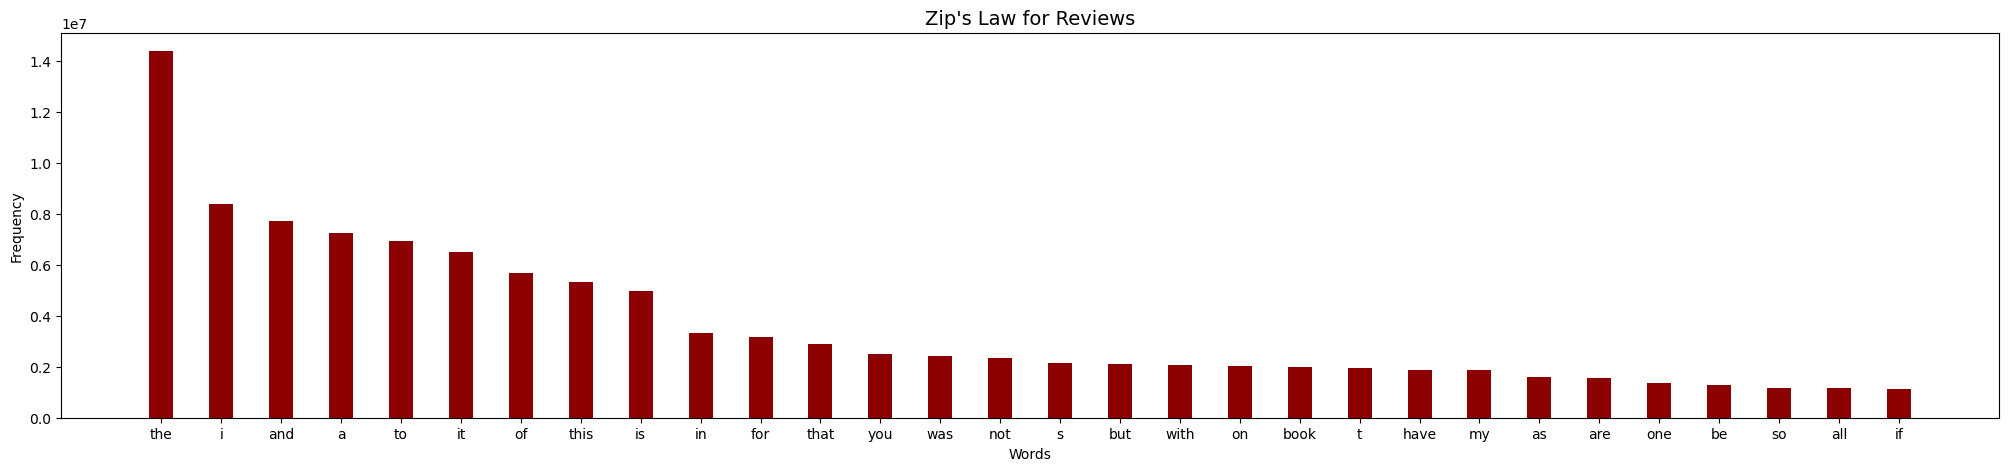

Vocabulary size: 884798


In [12]:
import matplotlib.pyplot as plt

vocab_sorted = sorted(full_vocab.items(), key=lambda x: x[1], reverse=True) #sort full_vocab from words with high frequency to low frequency

first_tokens = vocab_sorted[:30] # Take first 30 tokens of each vocabulary

fig = plt.figure(figsize = (25, 5))

#TODO: Create bar chart of the 30 most frequent words in positive reviews with appropriate title and axis labels
words, frequencies = zip(*first_tokens)
plt.bar(words, frequencies, color='darkred', width=0.4)

plt.title('Zip\'s Law for Reviews', fontsize=14)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.show()

print('Vocabulary size:',len(full_vocab))

In [13]:
positive_prior = len(df_train[df_train['label'] == 1]) / len(df_train) #calculate positive prior
negative_prior = len(df_train[df_train['label'] == 0]) / len(df_train) #calculate negative prior

In [14]:
def classify_review_2(text, likelihood, positive_prior, negative_prior):

    """ Calculates log scores for a new text given some prior probabilities and likelihoods
    Arguments
    ---------
    text : string
        Text to classify
    likelihood_positive : dictionary
        Dictionary of words and their log likelihood for positive reviews
    likelihood_negative : dictionary
        Dictionary of words and their log likelihood for negative reviews
    positive_prior : float
        Prior probability of a review being positive
    negative_prior : float
        Prior probability of a review being negative
    Returns
    -------
    predicted sentiment : string
        Predicted sentiment of the text
    sentiment_scores : tuple or dictionary
        Tuple of positive and negative sentiment scores
    """
    tokens = preprocess_text_2(text).split() # Preprocess the input review

    # Calculate the log scores for each sentiment category (take into account value for unseen tokens)
    log_score_positive = math.log(positive_prior)
    log_score_negative = math.log(negative_prior)

    for token in tokens:
        if token in likelihood:
            log_score_positive += likelihood[token]['positive']
            log_score_negative += likelihood[token]['negative']

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    predicted_sentiment = 'positive' if log_score_positive > log_score_negative else 'negative' # Determine the predicted sentiment based on the highest sentiment score

    return predicted_sentiment, sentiment_scores

In [15]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.2)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_2(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8636005392512703
Recall:  0.83277
F1 Score:  0.8479051061446826


In [16]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.4)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_2(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8643533941488424
Recall:  0.832865
F1 Score:  0.8483170959018522


In [17]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.6)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_2(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8649340533804133
Recall:  0.832845
F1 Score:  0.8485862754088339


In [18]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.8)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_2(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8651850004675665
Recall:  0.83268
F1 Score:  0.8486213520991831


# What if we just remove the punctuations and extra characters?

In [23]:
import re

def preprocess_text_3(text):
    """ Method to clean reviews from noise and standarize text across the different classes.
        The preprocessing includes converting to lowercase, removing punctuation, and removing stopwords.
    Arguments
    ---------
    text : String
        Text to clean
    Returns
    -------
    text : String
        Cleaned text
    """
    text = text.strip() #remove \n characters
    text = re.sub(r'[^\w\s]', ' ', text) #remove any punctuation or special characters
    text = re.sub(r'\d+', ' ', text) #remove numbers
    text = text.strip() #remove extra spaces

    return text

In [24]:
def create_dataframe_3(path_to_file):
  """ Creates dataframe of reviews and labels
  Arguments
  ---------
  path_to_file : str
      path to file to read
  Returns
  -------
  df : pandas dataframe
      Dataframe of reviews and labels
  """
  df={}
  index= 0
  with open(path_to_file) as f:
    for line in f:
      label_text, text = line.split(' ', 1)  #get label and review from line in file
      label = 0 if label_text == '__label__1' else 1 # get numeric value of label_text. If label_text is __label__1 then label = 0 if __label__2 label = 1
      text = preprocess_text_3(text) #preprocess text
      df[index] = {"label": label, "text": text} #create dictionary with keys "label" and "text" and set the correct values
      index+=1
  return pd.DataFrame.from_dict(df,orient='index')

In [25]:

df_train = create_dataframe_3('train.ft.txt')
df_test = create_dataframe_3('test.ft.txt')

full_vocab = vocab_dictionary(df_train)
positive_vocab = vocab_dictionary(df_train[df_train['label']==1]) #We create a positive vocab to keep track of words in positive reviews. This will come in handy later
negative_vocab = vocab_dictionary(df_train[df_train['label']==0]) #We create a negative vocab to keep track of words in negative reviews. This will come in handy later

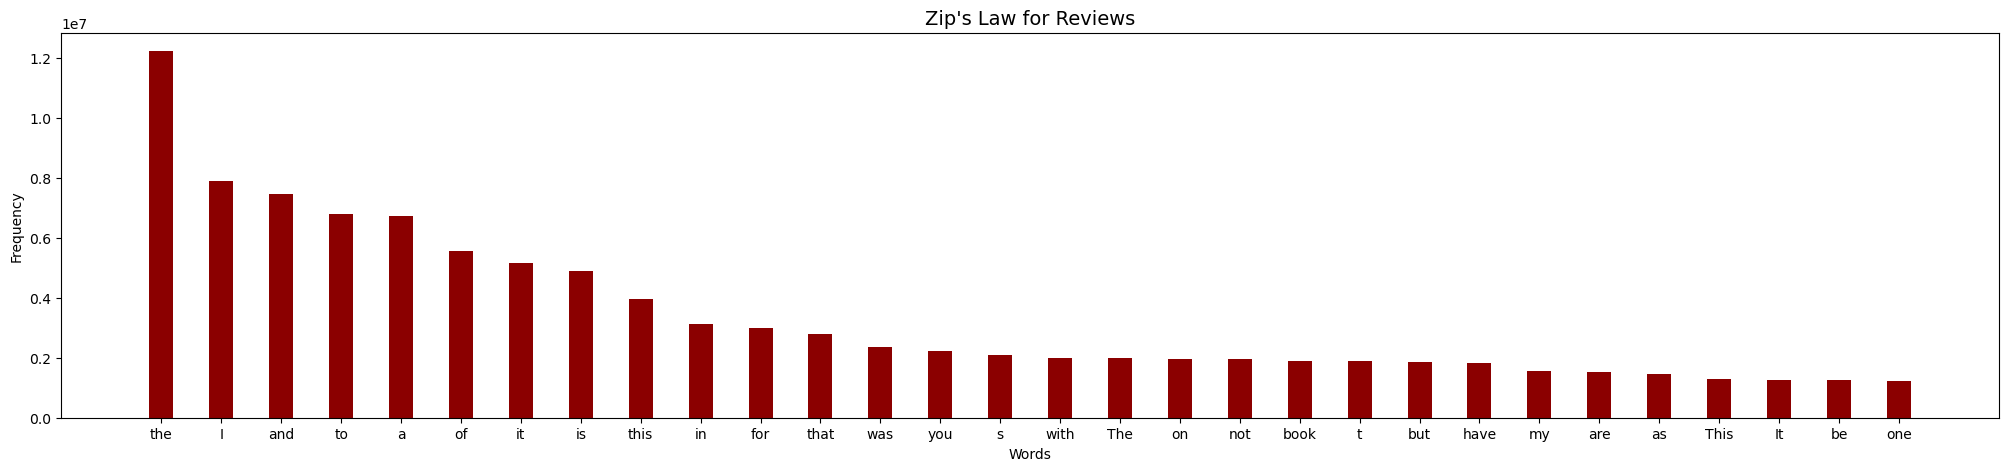

Vocabulary size: 1158198


In [26]:
import matplotlib.pyplot as plt

vocab_sorted = sorted(full_vocab.items(), key=lambda x: x[1], reverse=True) #sort full_vocab from words with high frequency to low frequency

first_tokens = vocab_sorted[:30] # Take first 30 tokens of each vocabulary

fig = plt.figure(figsize = (25, 5))

#TODO: Create bar chart of the 30 most frequent words in positive reviews with appropriate title and axis labels
words, frequencies = zip(*first_tokens)
plt.bar(words, frequencies, color='darkred', width=0.4)

plt.title('Zip\'s Law for Reviews', fontsize=14)
plt.xlabel('Words', fontsize=10)
plt.ylabel('Frequency', fontsize=10)

plt.show()

print('Vocabulary size:',len(full_vocab))

In [27]:
positive_prior = len(df_train[df_train['label'] == 1]) / len(df_train) #calculate positive prior
negative_prior = len(df_train[df_train['label'] == 0]) / len(df_train) #calculate negative prior

In [28]:
def classify_review_3(text, likelihood, positive_prior, negative_prior):

    """ Calculates log scores for a new text given some prior probabilities and likelihoods
    Arguments
    ---------
    text : string
        Text to classify
    likelihood_positive : dictionary
        Dictionary of words and their log likelihood for positive reviews
    likelihood_negative : dictionary
        Dictionary of words and their log likelihood for negative reviews
    positive_prior : float
        Prior probability of a review being positive
    negative_prior : float
        Prior probability of a review being negative
    Returns
    -------
    predicted sentiment : string
        Predicted sentiment of the text
    sentiment_scores : tuple or dictionary
        Tuple of positive and negative sentiment scores
    """
    tokens = preprocess_text_3(text).split() # Preprocess the input review

    # Calculate the log scores for each sentiment category (take into account value for unseen tokens)
    log_score_positive = math.log(positive_prior)
    log_score_negative = math.log(negative_prior)

    for token in tokens:
        if token in likelihood:
            log_score_positive += likelihood[token]['positive']
            log_score_negative += likelihood[token]['negative']

    sentiment_scores = {
        'positive': log_score_positive,
        'negative': log_score_negative,
    }

    predicted_sentiment = 'positive' if log_score_positive > log_score_negative else 'negative' # Determine the predicted sentiment based on the highest sentiment score

    return predicted_sentiment, sentiment_scores

In [29]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.2)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_3(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8675674279218766
Recall:  0.839545
F1 Score:  0.8533262184276058


In [30]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.4)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_3(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8682010639452828
Recall:  0.839685
F1 Score:  0.8537049698676515


In [31]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.6)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_3(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8685099449085689
Recall:  0.83948
F1 Score:  0.8537482679277425


In [32]:
likelihood = calculate_log_likelihood(full_vocab,positive_vocab,negative_vocab,0.8)

true_negatives = 0
false_negatives = 0
true_positives = 0
false_positives = 0

for index,review in df_test.iterrows():
  true_label = review['label']
  text = review['text']
  #TODO: Iterate through test set, compare true label with predicted label and get evaluation metrics (precision, recall and F1)
  # Be patient! This code might take a while
  predicted_sentiment, _ = classify_review_3(text, likelihood, positive_prior, negative_prior)
  if true_label == 0 and predicted_sentiment == 'negative':
    true_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'negative':
    false_negatives += 1
  elif true_label == 1 and predicted_sentiment == 'positive':
    true_positives += 1
  elif true_label == 0 and predicted_sentiment == 'positive':
    false_positives += 1

precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)

Precision:  0.8688175827816284
Recall:  0.83923
F1 Score:  0.8537675265584744


# Let's plot the results

In [36]:
x = [0.2, 0.4, 0.6, 0.8]

percision_full_preprocess = [0.853582095617368, 0.8543162816700973, 0.8546772611040786, 0.8550184361093452]
recall_full_preprocess = [0.840215, 0.840455, 0.840605, 0.84059]
f1_full_preprocess = [0.8468458026346292, 0.8473289561568222, 0.8475827247817659, 0.8477428301292153]

percision_no_preprocess = [0.8783116392840705, 0.8798839859125751, 0.8806584148656921, 0.881391432699604]
recall_no_preprocess = [0.8492, 0.84944, 0.848805, 0.847925]
f1_no_preprocess = [0.8635105282290764, 0.8643940164851938, 0.8644383678831671, 0.864334388363073]

percision_no_stopword = [0.8636005392512703, 0.8643533941488424, 0.8649340533804133, 0.8651850004675665]
recall_no_stopword = [0.83277, 0.832865, 0.832845, 0.83268]
f1_no_stopword = [0.8479051061446826, 0.8483170959018522, 0.8485862754088339, 0.8486213520991831]

percision_extra_characters = [0.8675674279218766, 0.8682010639452828, 0.8685099449085689, 0.8688175827816284]
recall_extra_characters = [0.839545, 0.839685, 0.83948, 0.83923]
f1_extra_characters = [0.8533262184276058, 0.8537049698676515, 0.8537482679277425, 0.8537675265584744]

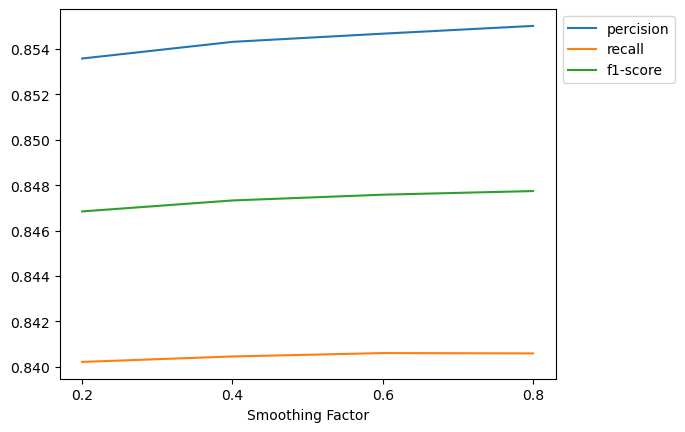

In [53]:
plt.plot(x, percision_full_preprocess, label = "percision")
plt.plot(x, recall_full_preprocess, label = "recall")
plt.plot(x, f1_full_preprocess, label = "f1-score")
plt.legend(bbox_to_anchor=(1., 1.0), loc='upper left')
plt.xlabel("Smoothing Factor")
plt.xticks(x)
plt.show()

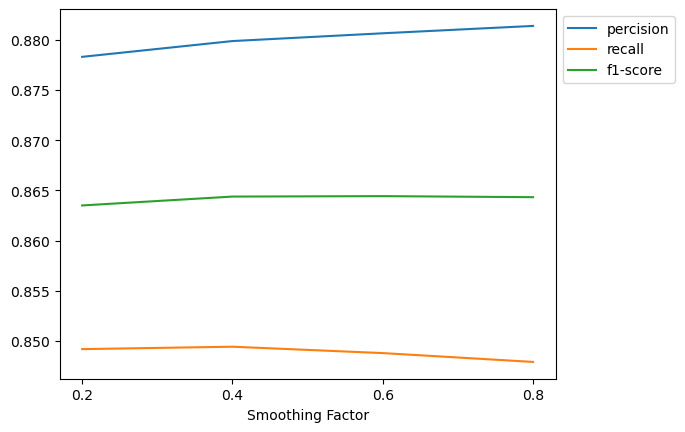

In [54]:
plt.plot(x, percision_no_preprocess, label = "percision")
plt.plot(x, recall_no_preprocess, label = "recall")
plt.plot(x, f1_no_preprocess, label = "f1-score")
plt.legend(bbox_to_anchor=(1., 1.0), loc='upper left')
plt.xlabel("Smoothing Factor")
plt.xticks(x)
plt.show()

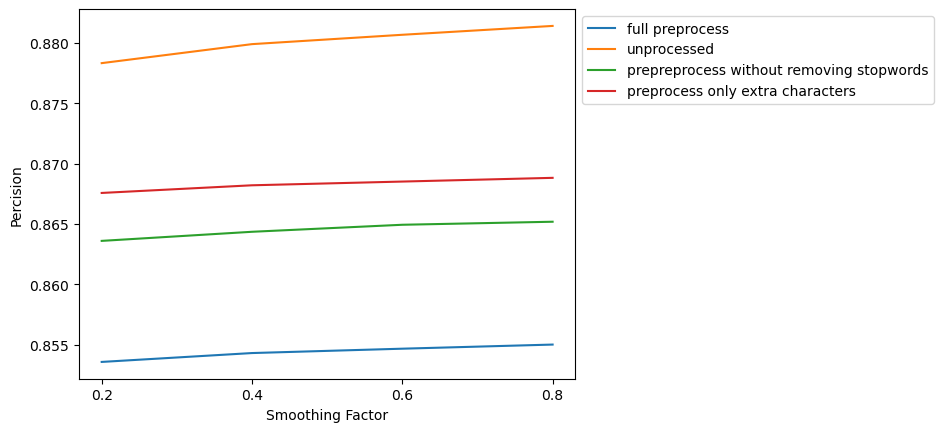

In [49]:
plt.plot(x, percision_full_preprocess, label = "full preprocess")
plt.plot(x, percision_no_preprocess, label = "unprocessed")
plt.plot(x, percision_no_stopword, label = "prepreprocess without removing stopwords")
plt.plot(x, percision_extra_characters, label = "preprocess only extra characters")
plt.legend(bbox_to_anchor=(1., 1.0), loc='upper left')
plt.xlabel("Smoothing Factor")
plt.ylabel("Percision")
plt.xticks(x)
plt.show()

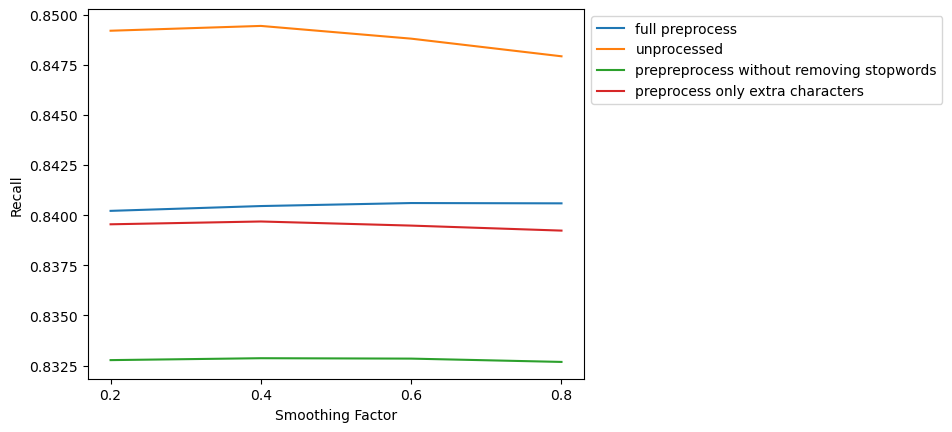

In [51]:
plt.plot(x, recall_full_preprocess, label = "full preprocess")
plt.plot(x, recall_no_preprocess, label = "unprocessed")
plt.plot(x, recall_no_stopword, label = "prepreprocess without removing stopwords")
plt.plot(x, recall_extra_characters, label = "preprocess only extra characters")
plt.legend(bbox_to_anchor=(1., 1.0), loc='upper left')
plt.xlabel("Smoothing Factor")
plt.ylabel("Recall")
plt.xticks(x)
plt.show()

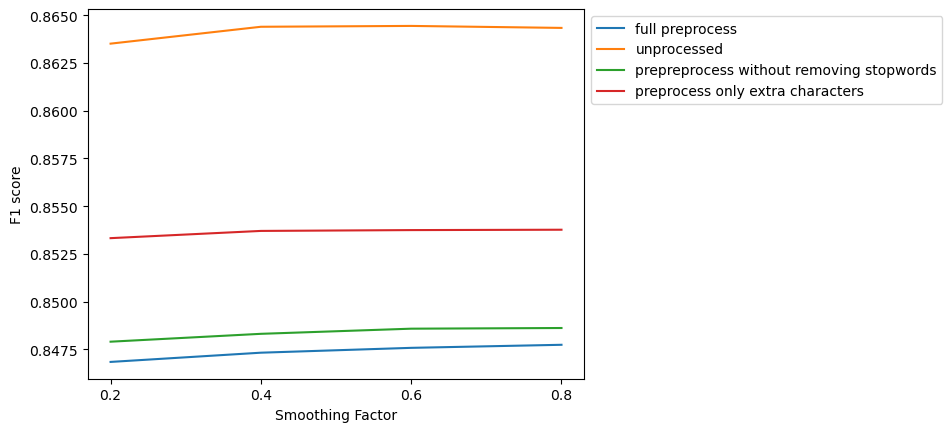

In [52]:
plt.plot(x, f1_full_preprocess, label = "full preprocess")
plt.plot(x, f1_no_preprocess, label = "unprocessed")
plt.plot(x, f1_no_stopword, label = "prepreprocess without removing stopwords")
plt.plot(x, f1_extra_characters, label = "preprocess only extra characters")
plt.legend(bbox_to_anchor=(1., 1.0), loc='upper left')
plt.xlabel("Smoothing Factor")
plt.ylabel("F1 score")
plt.xticks(x)
plt.show()